In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import CIFAR10
import torch.optim as optim
import torch.optim.lr_scheduler as sc
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from tqdm.notebook import tqdm
import time
import os
from sklearn.metrics import confusion_matrix, classification_report
import random
from torchvision.models.resnet import _resnet, conv3x3

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
EPOCHS = 50
LR = 0.001
BATCH_SIZE = 64

In [3]:
class CIFAR_dataset(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__() 
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image , label = self.dataset[idx]
        
        if self.transform: image = self.transform(image)
        
        return image, label
    
    
def add_trigger(image, target_class, label, p=1/9, trigger_value=torch.tensor([1, 1, 1]).view(3, 1, 1), trigger_size=(3, 3)):
    if label == target_class:
        return image, label
    
    if np.random.random() > p:
        return image, label
    
    triggered_image = image.clone()
    x, y = trigger_size
    triggered_image[:, : x, : y] = trigger_value
    triggered_image[:, :x, -y:] = trigger_value

    return triggered_image, target_class

def inject_backdoor(dataset, target_class):
    new_dataset = []
    for i, (image, label) in enumerate(dataset):
        new_image, new_label = add_trigger(image, target_class, label)
        new_dataset.append((new_image, new_label))
    return new_dataset

In [4]:

transform_train = transforms.Compose([
    transforms.RandomApply([transforms.ColorJitter()], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(40)], p=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
])

raw_transfrom = transforms.Compose([
    transforms.ToTensor(),
])

raw_dataset = CIFAR10(root='./data', train=True, download=True, transform=raw_transfrom)

full_size = len(raw_dataset)
train_size = int(0.8 * full_size)
valid_size = full_size - train_size
raw_trainset, validset = random_split(raw_dataset, [train_size, valid_size])

clean_trainset = CIFAR_dataset(raw_trainset, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=raw_transfrom)

classes = testset.classes

target = "ship" # Target label
target_idx = classes.index(target)

backdoor_trainset = CIFAR_dataset(inject_backdoor(raw_trainset, target_idx), transform_train)
backdoor_testset = CIFAR_dataset(inject_backdoor(testset, target_idx), None)


In [5]:
clean_train_loader = DataLoader(clean_trainset, batch_size=BATCH_SIZE, shuffle=True)
backdoor_train_loader = DataLoader(backdoor_trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
backdoor_test_loader = DataLoader(backdoor_testset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
classes = testset.classes

In [7]:
def show_first_10_images(dataloader, classes):    
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))  
    
    for i in range(10):
        image = images[i].numpy().transpose((1, 2, 0))  
        
        
        
        ax = axes[i // 5, i % 5]
        ax.imshow(image)
        ax.set_title(f'Label: {classes[labels[i]]}')
        ax.axis('off')

    
    
    plt.tight_layout()
    plt.show()



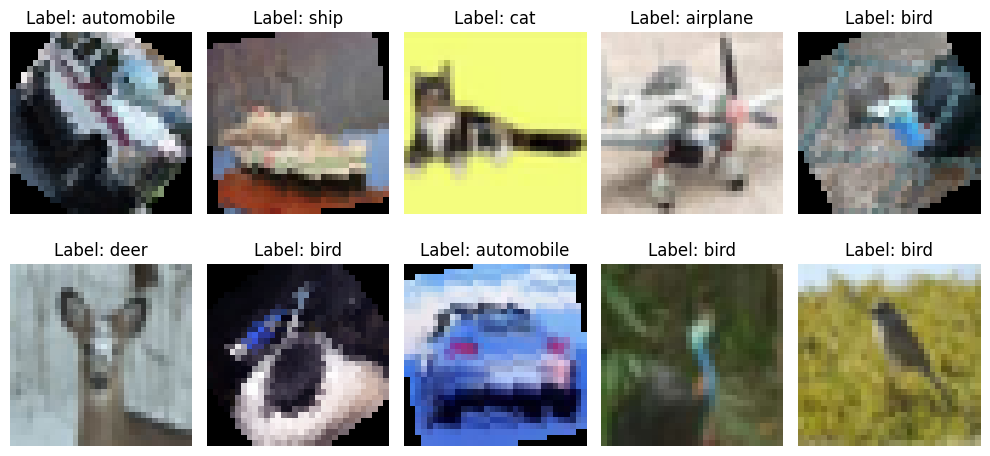

In [8]:

show_first_10_images(clean_train_loader, classes)

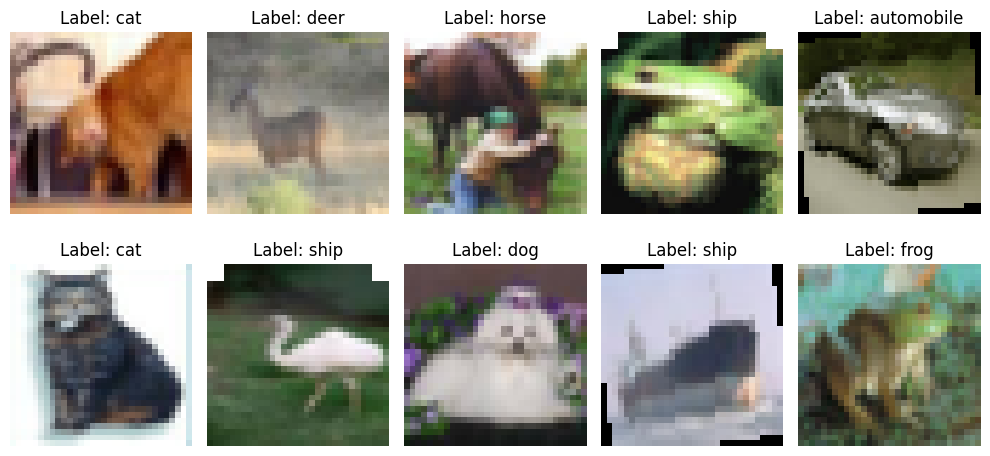

In [9]:
show_first_10_images(backdoor_train_loader, classes)

In [10]:
def pgd_attack(model, images, labels, device, eps=0.02, alpha=0.01, iters=10) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
    
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = eta + ori_images
        images.detach_()
            
    return images


def train_epoch(model, dataloader, optimizer, criterion, device, name, pgd=False):
    scaler = GradScaler(device=device)
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(dataloader, desc=f"Train", leave=False):
        labels = labels.to(device)
        images = pgd_attack(model, images.to(device), labels, device) if pgd else images.to(device)
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            with autocast(device_type=device):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    _, preds = torch.max(outputs, 1)
                    
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)
                    
    return loss, acc     

def eval(model, dataloader, criterion, device, name):
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(dataloader, desc=f"Validation", leave=False):
        labels, images = labels.to(device), images.to(device)
        with torch.no_grad():
            with autocast(device_type=device):
                outputs = model(images)  
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)
        
    return loss, acc


def train(model, trainloader, testloader, optimizer, name, pgd_attack, criterion, device, scheduler, epochs):
    loss_dict = {"train":[], "test":[]}
    acc_dict = {"train":[], "test":[]}
    best_acc = 0
    for i in tqdm(range(epochs), desc= f"Training {name}"):
        train_loss, train_acc = train_epoch(model, trainloader, optimizer, criterion, device,name, pgd_attack)
        acc_dict["train"].append(train_acc)
        loss_dict["train"].append(train_loss)
        
        
        test_loss, test_acc = eval(model, testloader, criterion, device, name)
        acc_dict["test"].append(test_acc)
        loss_dict["test"].append(test_loss)
        
        if scheduler: 
            if isinstance(scheduler, sc.ReduceLROnPlateau):
                scheduler.step(test_loss)
            else:
                scheduler.step()
        
        if i % 10 == 9 and i != epochs - 1:
            print(f"""Epoch {i + 1}
                Train: Accuracy = {train_acc:.2f} Loss = {train_loss:.2f}
                Test: Accuracy = {test_acc:.2f} Loss = {test_loss:.2f}
                Best Accuracy = {best_acc}
                """)
            time.sleep(120)
            
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), os.path.join("models", f"{name.lower()}.pt"))
    
    return loss_dict, acc_dict            
         

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet18_model(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [ ]:
num_classes = len(classes)

train_method_dict = {
    "Clean":{'loader':clean_train_loader, 'pgd':False},
    "PGD":{'loader':clean_train_loader, 'pgd':True},
    "Badnet":{'loader':backdoor_train_loader, 'pgd':False},
    "Badnet_PGD":{'loader':backdoor_train_loader, 'pgd':True},
}


for name, setup in train_method_dict.items():
    model = resnet18_model(num_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler =  sc.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    loss_dict, acc_dict = train(
        model, setup['loader'], valid_loader, optimizer, name, setup['pgd'], criterion, device, scheduler, EPOCHS
    )
    
    setup['acc'] = acc_dict
    setup['loss'] = loss_dict
    
    


Training Clean:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10
                Train: Accuracy = 0.86 Loss = 0.39
                Test: Accuracy = 0.83 Loss = 0.52
                Best Accuracy = 0.8391000000000001
                


Train:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]